In [2]:
%env CUDA_VISIBLE_DEVICES=3
%env LIBRARY_PATH=/usr/local/cuda/lib64
import sys
sys.path.append("/home/shirobokov/.local/lib/python3.6/site-packages/")

env: CUDA_VISIBLE_DEVICES=3
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [3]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [4]:
import h5py
import torch

/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [6]:
import os
list_of_images = []
list_of_masks = []
list_of_private = []
with open("/home/shirobokov/data/Images_2_data/pub/gt.txt", 'r') as file:
    for line in file:
        name = line.split()[1]
        list_of_images.append(plt.imread(os.path.join("/home/shirobokov/data/Images_2_data/pub/images", name)))
        list_of_masks.append(plt.imread(os.path.join("/home/shirobokov/data/Images_2_data/pub/gt", name)))
masks = np.array(list_of_masks)        
images = np.array(list_of_images)
images = images.transpose((0, 3, 1, 2))
print(masks.shape, images.shape)

(63, 213, 320) (63, 3, 213, 320)


In [7]:
num_of_val_images = 1
Val_images = images[-num_of_val_images:]
Val_masks = masks[-num_of_val_images:]
images = images[:-num_of_val_images]
masks = masks[:-num_of_val_images]
print(masks.shape, Val_masks.shape)

(62, 213, 320) (1, 213, 320)


In [8]:
# plt.figure(figsize=(20,10))
# for i in range(num_of_val_images):
#     plt.subplot(1,num_of_val_images, i+1)
#     plt.imshow(Val_images[i].transpose(1,2,0))

In [9]:
def make_crops(images, size=11):
    crops = np.zeros((images.shape[2] * images.shape[3] * len(images), 3, size, size))
    half_size = size // 2
    calc = 0
    for image in images:
        image = np.pad(image, ((0,0), (half_size, half_size), (half_size, half_size)),
                       'constant', constant_values=0)
        for i in range(half_size, image.shape[1] - half_size):
            for j in range(half_size, image.shape[2] - half_size):
                crop = image[:, i - half_size: i + half_size + 1, j - half_size:j + half_size + 1]
                crops[calc] = crop
                calc += 1
    return crops

In [10]:
y_train = []
for mask in masks:
    y_train.extend(mask.ravel())
y_train = np.array(y_train)    

print(y_train.shape)

y_test = []
for mask in Val_masks:
    y_test.extend(mask.ravel())
y_test = np.array(y_test)
print(y_test.shape)


(4225920,)
(68160,)


In [11]:
X_train = make_crops(images)
X_test = make_crops(Val_images)
print(X_train.shape, X_test.shape)

(4225920, 3, 11, 11) (68160, 3, 11, 11)


### Train model

In [12]:
# An auxilary function that returns mini-batches for neural network training
from sklearn.metrics import accuracy_score
import time
from pandas import ewma
from IPython import display
from tqdm import trange

def iterate_minibatches(X, y, batchsize, shuffle=False):
    indices = np.arange(len(X))
    if shuffle: 
        indices = np.random.permutation(indices)
    for start in trange(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [13]:
model = torch.nn.Sequential()
model.add_module('conv_1', nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1, padding=0))
#model.add_module("maxpool_1", torch.nn.MaxPool2d(kernel_size=2))
model.add_module("bn1", torch.nn.BatchNorm2d(64))
model.add_module("relu_1", torch.nn.ReLU())

model.add_module('conv_2', nn.Conv2d(64, 128, kernel_size=(2,2), stride=1, padding=0))
model.add_module("maxpool_1", torch.nn.MaxPool2d(kernel_size=2))
model.add_module("bn2", torch.nn.BatchNorm2d(128))
model.add_module("relu_2", torch.nn.ReLU())
model.add_module("dropout_1", torch.nn.Dropout(p=0.5))                 

model.add_module('conv_3', nn.Conv2d(128, 256, kernel_size=(3,3), stride=1, padding=0))
model.add_module("bn3", torch.nn.BatchNorm2d(256))
model.add_module("relu_3", torch.nn.ReLU())    
model.add_module("dropout_2", torch.nn.Dropout(p=0.15))


model.add_module("flat", Flatten())

model.add_module("fc1", torch.nn.Linear(1024, 1024))
model.add_module("relu_4", torch.nn.ReLU())
model.add_module("dropout_4", torch.nn.Dropout(p=0.5))
model.add_module("fc5", torch.nn.Linear(1024, 1024))
model.add_module("relu_5", torch.nn.ReLU())

model.add_module("fc6", torch.nn.Linear(1024, 2))
model.add_module("sigmoid", torch.nn.LogSoftmax(1))

model.cuda(0)

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (maxpool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (relu_2): ReLU()
  (dropout_1): Dropout(p=0.5)
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (relu_3): ReLU()
  (dropout_2): Dropout(p=0.15)
  (flat): Flatten(
  )
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (relu_4): ReLU()
  (dropout_4): Dropout(p=0.5)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (relu_5): ReLU()
  (fc6): Linear(in_features=1024, out_features=2, bias=True)
  (sigmoid): LogSoftmax()
)

In [18]:
def train_unary_model(model, X_train, y_train, X_test, y_test, num_epochs=5, batch_size=1024, auc_history=None):
    opt = torch.optim.Adamax(model.parameters(), lr=0.002 / 2)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:

        train_err = train_acc = 0
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
            X_batch = Variable(torch.FloatTensor(X_batch)).cuda(0)
            y_batch = Variable(torch.LongTensor(y_batch)).cuda(0)

            y_predicted = model(X_batch)
            loss = torch.nn.functional.nll_loss(y_predicted, y_batch).mean()

            loss.backward()
            opt.step()
            opt.zero_grad()

            train_err += loss.data.cpu().numpy()[0]
            train_acc += torch.eq(torch.max(y_predicted, 1)[1], y_batch).data.cpu().numpy().mean()

        # And a full pass over the validation data:
        y_pred = []

        model.train(False)
        for X_batch, y_batch in iterate_minibatches(X_test, y_test, batch_size, shuffle=False):
            X_batch = Variable(torch.FloatTensor(X_batch)).cuda(0)
            y_pred.extend(model(X_batch).data.cpu().numpy())

        y_pred = np.asarray(y_pred)

        val_acc = accuracy_score(y_test, np.argmax(y_pred, 1))
        #val_roc_auc = roc_auc_score(y_test, y_pred)
        auc_history.append(val_acc)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        plt.title("Validation accuracy")
        plt.xlabel("#iteration")
        plt.ylabel("accuracy")
        plt.plot(auc_history, 'b',label='val auc')
        plt.plot(ewma(np.array(auc_history), span=10),'r',label='ewm val accuracy')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))

        train_batches = np.ceil(len(X_train) / batch_size)
        print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
        print("  validation accuracy:\t\t{:.2f} %".format(val_acc * 100))
        #print("  validation roc_auc:\t\t{:.2f} %".format(val_roc_auc * 100))

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


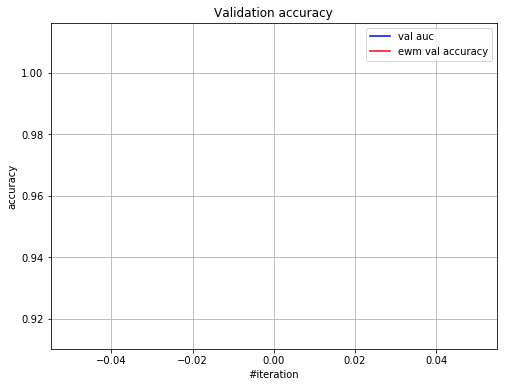

Epoch 1 of 1 took 351.952s
  training loss (in-iteration):		0.110609
  train accuracy:		96.17 %
  validation accuracy:		96.32 %


In [19]:
auc_history = []
train_unary_model(model, X_train, y_train, X_test, y_test, num_epochs=5, batch_size=1024, auc_history=auc_history)

## Pair potentials

In [20]:
from scipy.signal import convolve2d


def create_filter(row, col, val=-1, center_value=1):
    filters = np.array([[0,0,0],
                        [0,center_value,0],
                        [0,0,0]])
    filters[row, col] = val
    return filters


from functools import reduce
def get_pair_potential(image, filters, A=0, B=1, sigma=1):
    pairwise_diff = np.array(
                    [reduce(lambda x, y: x + y,
                        [convolve2d(image[channel], filters[index], mode='same', boundary='symm') ** 2
                         for channel in range(image.shape[0])])
                    for index in range(len(filters))]
            )
    return A + B * np.exp(- pairwise_diff / 2 / sigma ** 2)



import maxflow
def define_graph(image, nn_predictions):
    filters = [create_filter(row, col) for row, col in [(0, 1), (1, 2), (2, 1), (1, 0)]]
    filters = np.array(filters)
    graph_filters = [create_filter(row, col, val=1, center_value=0) for row, col in [(0, 1), (1, 2), (2, 1), (1, 0)]]
    graph_filters = np.array(graph_filters)


    g = maxflow.Graph[float]()
    nodes = g.add_grid_nodes(image.shape[1:])

    for weights, structure in zip(get_pair_potential(image, filters, A=10, B=0.5, sigma=1), graph_filters):
        g.add_grid_edges(nodes, weights, structure=structure) 
    
    # Improves quality, making less holes
    positive_predictions = -np.log(np.clip(np.exp(-nn_predictions[:,1]) + 0., 0, 1))
    g.add_grid_tedges(nodes,
                      positive_predictions.reshape(image_to_test.shape[1:]),
                      nn_predictions[:, 0].reshape(image_to_test.shape[1:]))
    return g, nodes


def segmentation(images, model):
    images_masks = []
    for img in images:
        nn_pred = []
        for X_b, y_b in iterate_minibatches(make_crops(img[None]), make_crops(img[None]), 10000):
            nn_pred.extend(model(Variable(torch.FloatTensor(X_b).cuda(0))).data.cpu().numpy())
        pred = - np.array(nn_pred)

        g, nodes = define_graph(img, pred)
        g.maxflow() 
        images_masks.append(g.get_grid_segments(nodes))
    return images_masks

### Graph creation

100%|██████████| 7/7 [00:01<00:00,  5.20it/s]


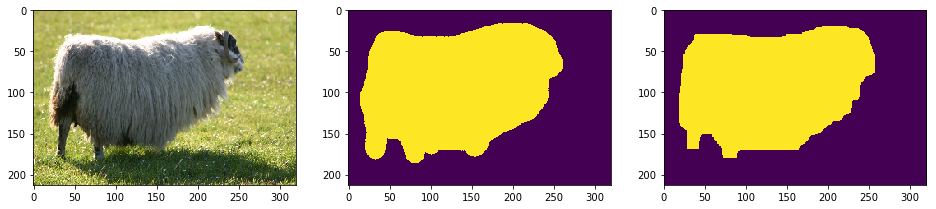

In [21]:
index = 0
image_to_test = Val_images[index]
mask_to_test = Val_masks[index]

learned_mask = segmentation([image_to_test], model)[0]

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.imshow(image_to_test.transpose(1,2,0))
plt.subplot(1,3,2)
plt.imshow(mask_to_test)
plt.subplot(1,3,3)
plt.imshow(learned_mask)

### Predict Test data

In [22]:
from itertools import chain
def run_length_enc(label):
    x = label.transpose().flatten()
    y = np.where(x > 0)[0]
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return res

In [23]:
list_of_private = []
list_of_private_names = []
for name in os.listdir("/home/shirobokov/data/Images_2_data/images"):
    if not str.startswith(name, "."):
        list_of_private_names.append(name)
        list_of_private.append(plt.imread(os.path.join("/home/shirobokov/data/Images_2_data/images", name)))
priv_images = np.array(list_of_private)
priv_images = priv_images.transpose((0, 3, 1, 2))
print(priv_images.shape)

(20, 3, 213, 320)


In [24]:
with open("solution.txt", 'w') as f:
    f.write("img,pixels\n")
    for image, name in zip(priv_images, list_of_private_names):
        priv_mask = segmentation([image], model)[0]
        encoded = run_length_enc(priv_mask)
        f.write(name + ",")
        for value in encoded:
            f.write(str(value) + " ")
        f.write("\n")

100%|██████████| 7/7 [00:01<00:00,  5.34it/s]
